In [1]:
using JLD
using PyPlot
using Statistics
using StatsBase 
using LinearAlgebra
using Clustering

In [2]:
using JLD2
using FileIO

In [3]:
using MultivariateStats

In [4]:
data = load("../data/experiment/images.jld")

Dict{String,Any} with 5 entries:
  "ImagesIS2"   => [0 0 … 0 0; 0 0 … 0 0; … ; 43 33 … 35 15; 23 140 … 44 28]…
  "ImagesBTV50" => [10 3 … 0 0; 3 0 … 0 0; … ; 6 0 … 0 0; 4 0 … 0 0]…
  "charge"      => [0.1298, 0.1712, 0.095, 0.0433, 0.097, 0.136, 0.1404, 0.1837…
  "ImagesBTV26" => [81 24 … 14 0; 70 49 … 37 0; … ; 38 54 … 23 3; 69 22 … 23 4]…
  "ImagesBTV53" => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 21 0; 0 0 … 0 0]…

In [5]:
cam_1 = data["ImagesBTV50"]
charge  = data["charge"]

enumerate_events = collect(1:length(charge));

In [6]:
intensity(x) = [sum(x, dims=(2, 3))...]

intensity (generic function with 1 method)

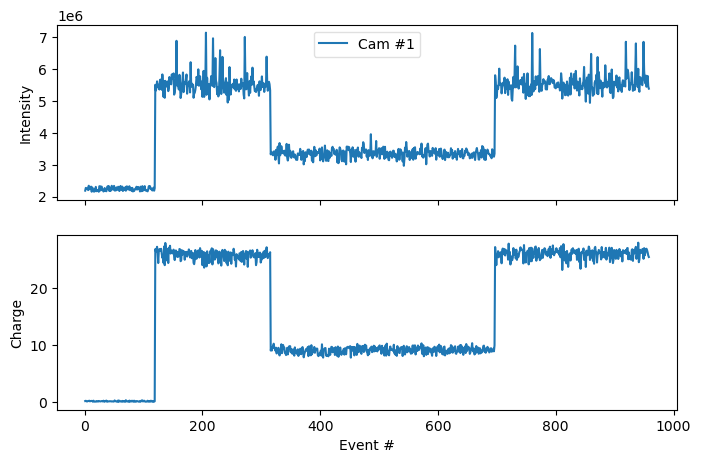

PyObject Text(0.5, 24.0, 'Event #')

In [7]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(8,5), sharex=true)

ax.plot(enumerate_events, intensity(cam_1), label="Cam #1")
ax.legend(loc="upper center", frameon=true, framealpha=0.6, ncol=2, )

ax2.plot(enumerate_events, charge)

ax.set_ylabel("Intensity", )
ax2.set_ylabel("Charge", )
ax2.set_xlabel("Event #")

In [8]:
cam_1_frame = (x=(160, 260), y=(140, 220))

(x = (160, 260), y = (140, 220))

In [9]:
event_mask = 5. .< charge .< 15.
# event_mask = charge .> 15.
# event_mask = charge .> -2.
# event_mask = 800:900

cam_1_m1 = cam_1[event_mask,:,:]
charge_m1 = charge[event_mask] .* 1.0
cam_1_m1 = round.(Int64, cam_1_m1[:,cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]]);

# Cam 1 

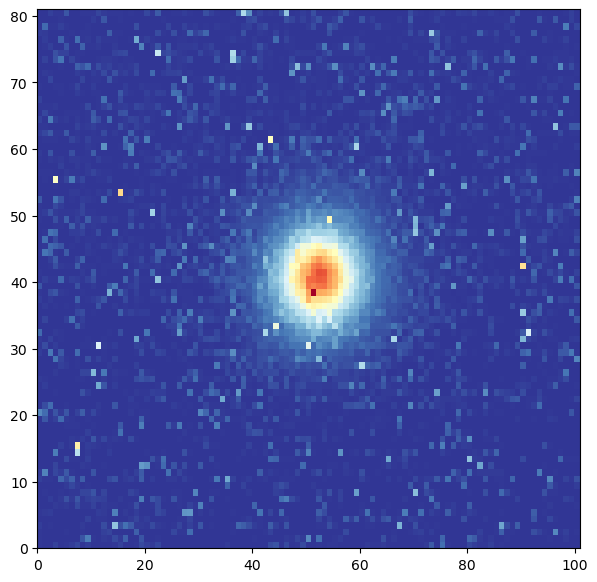

PyObject <matplotlib.collections.QuadMesh object at 0x7fc94a886160>

In [10]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.pcolormesh(cam_1_m1[1,:,:], cmap="RdYlBu_r")

In [11]:
sz = size(cam_1_m1)

data_flat = [reshape(cam_1_m1[i,:,:], :) for i in 1:sz[1]]
data_flat = convert.(Float64, hcat(data_flat...));

In [12]:
sz

(381, 81, 101)

In [13]:
# data_reconst = reshape(data_flat[:,1], size(cam_1_m1)[2:3])
# plt.imshow(data_reconst)
# plt.imshow(cam_1_m1[1,:,:])

In [14]:
M = fit(PCA, data_flat, maxoutdim=100)

pca_data = transform(M, data_flat);

In [15]:
cv1 = cov(data_flat')
cv2 = cov(pca_data');

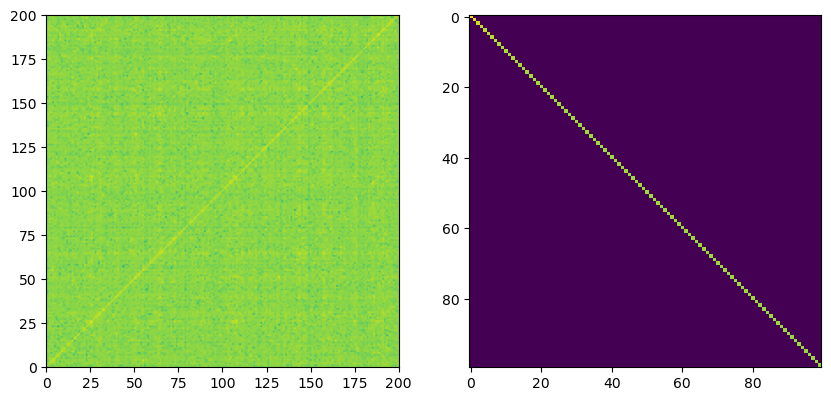

(0.0, 200.0)

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

fig.subplots_adjust(hspace=0.1, wspace=0.2)

ax[1].imshow(log.(abs.(cv1)))
ax[2].imshow(log.(cv2 .+ 1e-5))

ax[1].set_xlim(0, 200)
ax[1].set_ylim(0, 200)

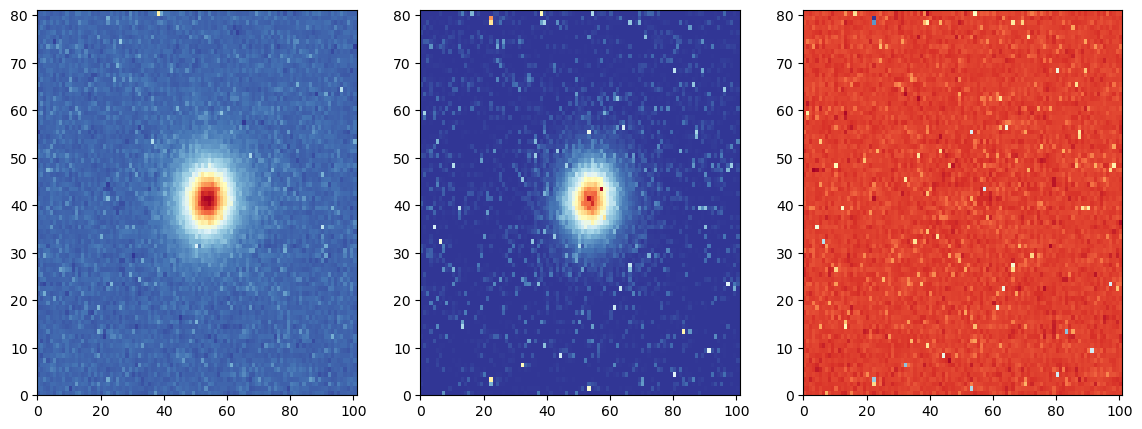

PyObject <matplotlib.collections.QuadMesh object at 0x7fc638c52730>

In [17]:
img_new = reconstruct(M, pca_data)

img_ind = 5
img_new =  reshape(img_new', size(cam_1_m1))

fig, ax = plt.subplots(1,3, figsize=(14,5))

ax[1].pcolormesh(img_new[img_ind,:,:], cmap="RdYlBu_r")
ax[2].pcolormesh(cam_1_m1[img_ind, :, :], cmap="RdYlBu_r")
ax[3].pcolormesh(img_new[img_ind,:,:] .- cam_1_m1[img_ind, :, :], cmap="RdYlBu_r")

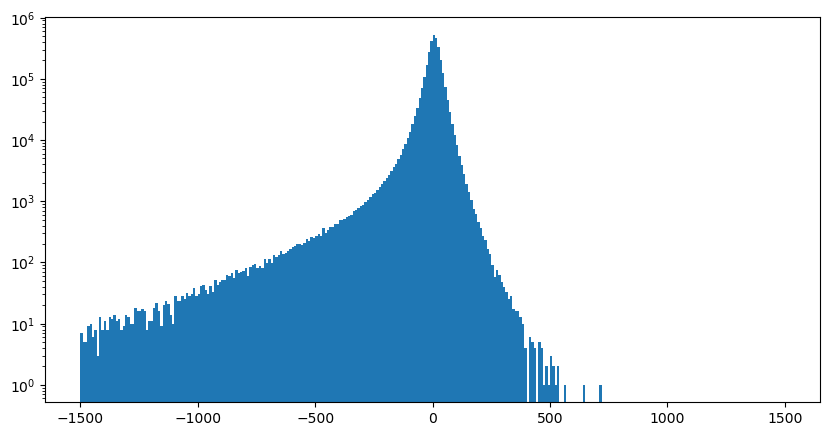

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.hist([img_new .- cam_1_m1...], bins=-1500:10:1500);
ax.set_yscale("log")

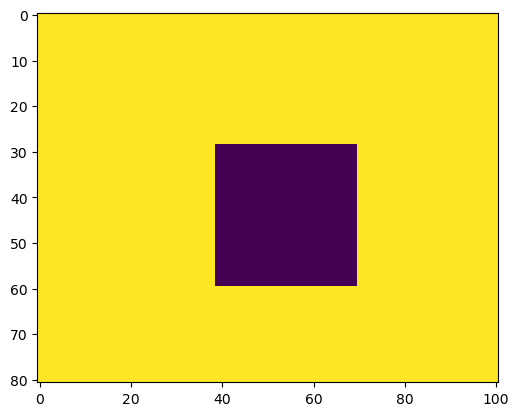

PyObject <matplotlib.image.AxesImage object at 0x7fc63f74fee0>

In [19]:


background_m = ones(size(cam_1_m1[1,:,:]))
background_m[30:60, 40:70] .=  0.0

plt.imshow(background_m)

In [20]:
# fig, ax = plt.subplots(1,3, figsize=(14,5))

# ax[1].scatter(pca_data[2,:], pca_data[1,:])
# ax[2].scatter(pca_data[3,:], pca_data[1,:])
# ax[3].scatter(pca_data[4,:], pca_data[1,:])

# ax[1].set_ylabel("PCA 1")
# ax[1].set_xlabel("PCA 2")
# ax[2].set_xlabel("PCA 3")
# ax[3].set_xlabel("PCA 4")

In [21]:
color_list = plt.cm.Spectral(range(0.0, stop=1, length=10))
# colors = [color_list[i+1] for i in labels];

charge_resc = charge_m1 .- minimum(charge_m1)
charge_resc = charge_resc ./ maximum(charge_resc);

In [22]:
kmeans_res = kmeans(pca_data, 2)

colors_kmeans = [i/maximum(kmeans_res.assignments) for i in kmeans_res.assignments];

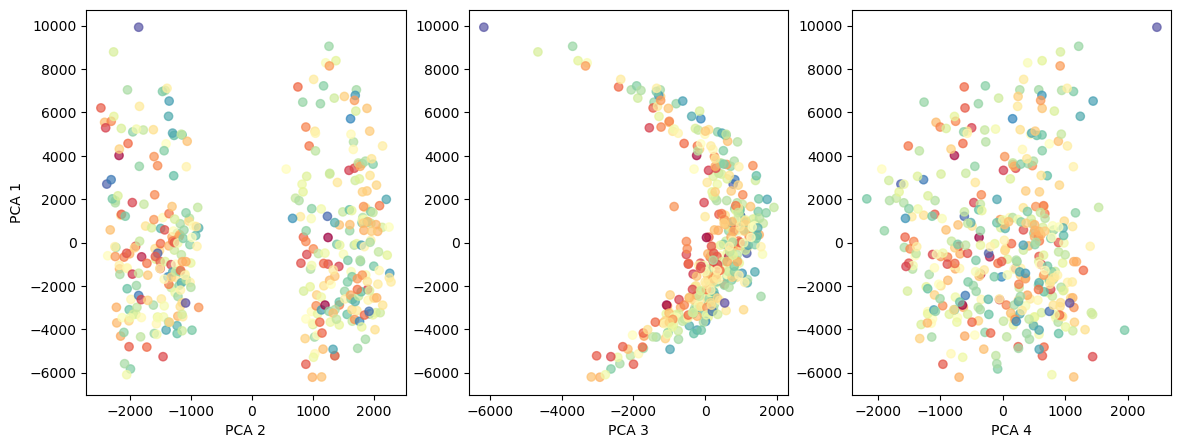

PyObject Text(0.5, 24.0, 'PCA 4')

In [23]:
fig, ax = plt.subplots(1,3, figsize=(14,5))

ax[1].scatter(pca_data[2,:], pca_data[1,:], alpha=0.7, c=plt.cm.Spectral.(charge_resc), cmap="Spectral")
ax[2].scatter(pca_data[3,:], pca_data[1,:], alpha=0.7, c=plt.cm.Spectral.(charge_resc), cmap="Spectral")
ax[3].scatter(pca_data[4,:], pca_data[1,:], alpha=0.7, c=plt.cm.Spectral.(charge_resc), cmap="Spectral")

ax[1].set_ylabel("PCA 1")
ax[1].set_xlabel("PCA 2")
ax[2].set_xlabel("PCA 3")
ax[3].set_xlabel("PCA 4")

In [24]:
ax[1].scatter(pca_data[2,:], pca_data[1,:], c=plt.cm.Spectral.(colors_kmeans), cmap="Spectral")
ax[2].scatter(pca_data[3,:], pca_data[1,:], c=plt.cm.Spectral.(colors_kmeans), cmap="Spectral")
ax[3].scatter(pca_data[4,:], pca_data[1,:], c=plt.cm.Spectral.(colors_kmeans), cmap="Spectral")

ax[1].set_ylabel("PCA 1")
ax[1].set_xlabel("PCA 2")
ax[2].set_xlabel("PCA 3")
ax[3].set_xlabel("PCA 4")

PyObject Text(0.5, 24.0, 'PCA 4')

In [25]:
# fig, ax = plt.subplots(1,1, figsize=(14,5))

# ax.plot(kmeans_res.assignments)

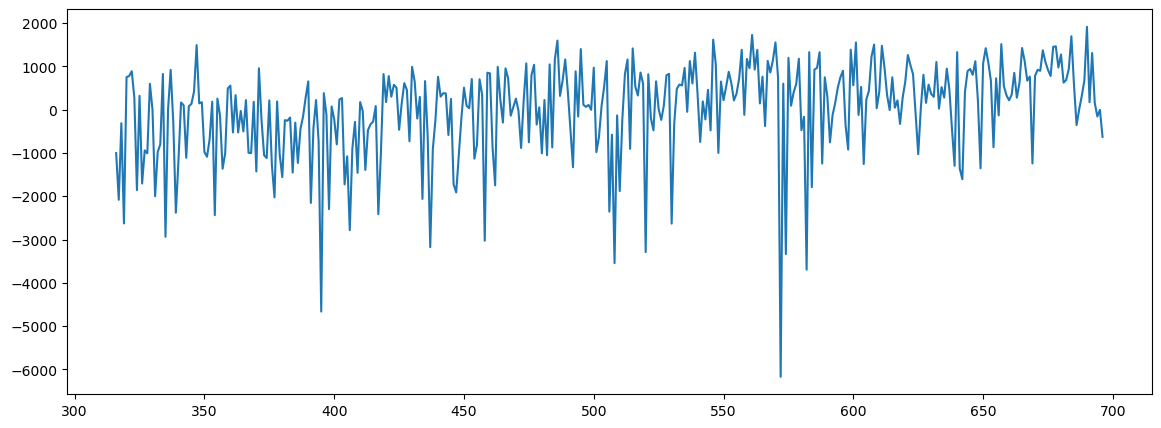

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc63e00e0a0>

In [26]:
fig, ax = plt.subplots(1,1, figsize=(14,5))

ax.plot(enumerate_events[event_mask], pca_data[3,:])

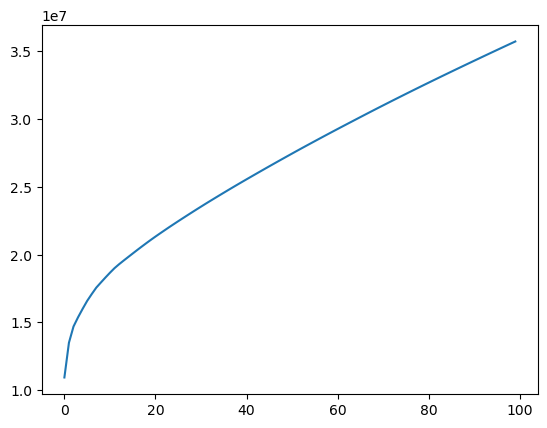

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc63da69c40>

In [27]:
plt.plot(cumsum(sort(M.prinvars, rev=true)))

In [28]:
M.tvar

6.5303071375713855e7